In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from   tensorflow import keras

# Resolviendo ecuaciones con Physics-Informed Neural Networks (PINNs)

Resolvamos el oscilador armónico subamortiguado:

$$ m \frac{ d^2 x}{dt^2} + \mu \frac{dx}{dt} + k x = 0 $$

Adaptado de: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

In [ ]:
def MLP(din, depth, width, dout):
    """Vanilla MLP"""
    # Input layer
    coords = keras.layers.Input(din, name='coords')

    # Hidden layers
    hidden = coords
    for ii in range(depth):
        hidden = keras.layers.Dense(width, activation='tanh')(hidden)

    # Output layers
    fields = keras.layers.Dense(dout)(hidden)

    # Assemble model
    model = keras.Model(inputs=coords, outputs=fields)

    return model

def oscillator(dd, w0, xx):
    """Analytical solution to the 1D underdamped harmonic oscillator problem""" 
    wt = np.sqrt(w0**2-dd**2)
    phi = np.arctan(-dd/wt)
    A = 1/(2*np.cos(phi))
    osc = np.cos(phi+wt*xx)
    damp = np.exp(-dd*xx)
    yy  = damp*2*A*osc
    return yy

def xdot(dd, w0, xx):
    """Time derivative of the analytical solution to the 1D underdamped harmonic oscillator problem""" 
    wt = np.sqrt(w0**2-dd**2)
    phi = np.arctan(-dd/wt)
    A = 1/(2*np.cos(phi))
    osc = np.cos(phi+wt*xx)
    cso = np.sin(phi+wt*xx)
    damp = np.exp(-dd*xx)
    yy  = damp*2*A*osc
    return -dd*yy - wt*damp*2*A*cso

In [ ]:
# Generate data
xx = np.linspace(0, 1, num=500)
dd = 2
w0 = 20 
yy = oscillator(dd, w0, xx)
yp = xdot(dd, w0, xx)

# Training data
x_data = xx[0:200:20].reshape(-1, 1)
y_data = yy[0:200:20].reshape(-1, 1)

## Sin física

En este primer intento vamos usar una MLP para hacer regresión sobre los datos disponibles, y así aproximar la solución.

In [ ]:
model = MLP(1, 3, 32, 1)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

num_epochs = 1000
for epoch in range(num_epochs):

    with tf.GradientTape() as tape:
        y_pred = model(x_data)
        loss_data = tf.reduce_mean(tf.square(y_pred - y_data))

    # Get gradients
    gradients = tape.gradient(loss_data, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Grafico la solución

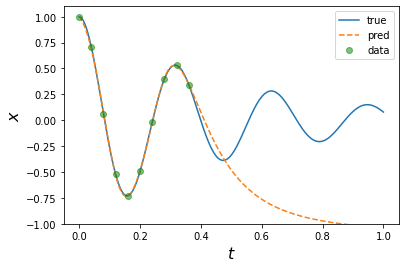

In [ ]:
# Plot
plt.plot(xx, yy, label='true')
plt.plot(xx, model(xx), ls='--', label='pred')
plt.ylim(-1, 1.1) 
plt.plot(x_data, y_data, 'go', alpha=0.5, label='data')
plt.legend()
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)

Grafico la derivada

Text(0, 0.5, '$dx/dt$')

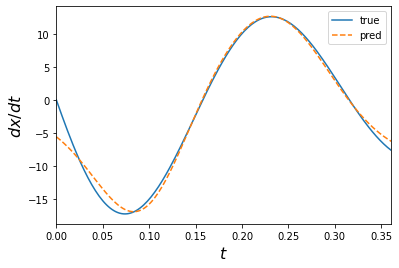

In [ ]:
# Calculate derivative
xt = tf.convert_to_tensor(xx)
with tf.GradientTape() as tape:
  tape.watch(xt)
  out = model(xt)
dy = tape.gradient(out, xt)

# Plot
plt.plot(xx, yp, label='true')
plt.plot(xx, dy, ls='--', label='pred')
plt.xlim(0, x_data[-1])
plt.legend()
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$dx/dt$', fontsize=16)

## Con Física

Ahora vamos enforzar también que los residuales de la solución vayan a cero en los puntos de colocación, de esta forma la red solo puede vivir dentro del espacio de funciones que cumplen la ecuación diferencial

In [ ]:
model = MLP(1, 2, 32, 1)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
collocs = np.linspace(0, 1, num=30, dtype=np.float32).reshape(-1, 1)
collocs = tf.convert_to_tensor(collocs)

num_epochs = 20000
acc_data = []
acc_phys = []
for epoch in range(num_epochs):

    with tf.GradientTape() as tape:
        y_pred = model(x_data)
        loss_data = tf.reduce_mean((y_pred - y_data)**2.0)
        
        # Calculate the residuals
        with tf.GradientTape() as phys_2:
            phys_2.watch(collocs)
            with tf.GradientTape() as phys_1:
                phys_1.watch(collocs)
                yp = model(collocs)

            dy  = phys_1.gradient(yp, collocs)
        dy2 = phys_2.gradient(dy,  collocs)

        residuals = dy2 + (2*dd)*dy + (w0**2)*yp
        loss_phys = tf.reduce_mean(residuals**2.0)

        loss = loss_data + 1e-4*loss_phys

        if epoch%100==0:
          acc_data.append(loss_data)
          acc_phys.append(1e-4*loss_phys)

    # Get gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Text(0, 0.5, '$x$')

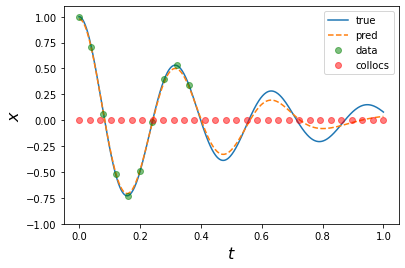

In [ ]:
# Plot
plt.plot(xx, yy, label='true')
plt.plot(xx, model(xx), ls='--', label='pred')
plt.plot(x_data, y_data, 'go', alpha=0.5, label='data')
plt.plot(collocs, 0*collocs, 'ro', alpha=0.5, label='collocs')
plt.ylim(-1, 1.1) 
plt.legend()
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)

Text(0, 0.5, '$dx/dt$')

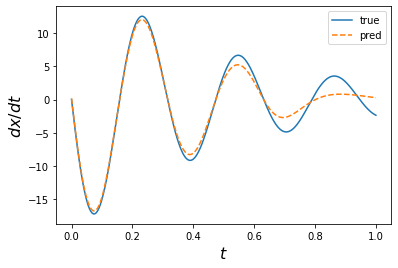

In [ ]:
# Calculate derivative
xt = tf.convert_to_tensor(xx)
with tf.GradientTape() as tape:
  tape.watch(xt)
  out = model(xt)
dy = tape.gradient(out, xt)

# Plot
yp = xdot(dd, w0, xx)
plt.plot(xx, yp, label='true')
plt.plot(xx, dy, ls='--', label='pred')
plt.legend()
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$dx/dt$', fontsize=16)

Text(0.5, 0, 'Epochs')

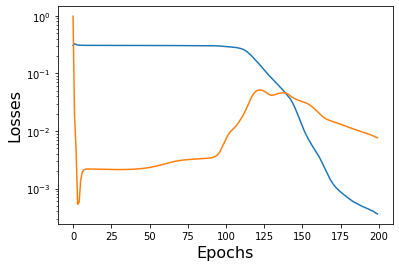

In [ ]:
# Plot losses
plt.semilogy(acc_data, label='data')
plt.semilogy(acc_phys, label='phys')
plt.ylabel("Losses", fontsize=16)
plt.xlabel("Epochs", fontsize=16)